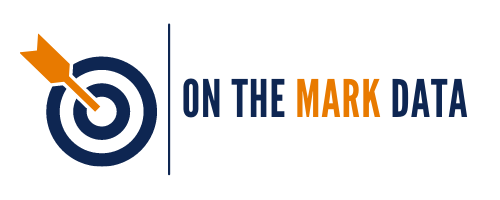

# 🐍 Intro to Analyzing JSON Data with Python
This notebook will teach us how to parse JSON data to answer analytics questions. My goal with this notebook is for you to learn the following:
- Why JSON data is so important
- How to use the requests package to load JSON data from data.gov
- Navigating nested schemas of JSON data
- Potential pitfalls to look out for when analyzing JSON data
- Converting complex JSON into a flat file to answer business questions

### 💻 Why you should learn about JSON analytics:
- If you are a data scientist, learning how to utilize upstream data sources in a raw format will set you apart and enable you to take on more complex projects, as so much data is sourced from APIs in the form of JSON.
- If you are a data engineer, understanding the downstream analytics needs can help you create better schemas and data pipelines if your downstream users utilize the data for analytics.

### 📋 Our use case for this exercise:
You are part of a data team working for a grocery store chain that is currently building an app to shop online. A vital piece of this app is providing the recommended storage timelines for the food. You are using data directly from the USDA government agency, `FSIS FoodKeeper`, which provides the data as a JSON. Since your team is new to the data, you were tasked with answering a "simple" question to help the team better understand the JSON data.

👉🏽 **ASK: Which food products are not recommended to be stored in the refrigerator?**

# Import Packages

In [ ]:
import requests
import pandas as pd

# Import Data

In [ ]:
food_keeper_json = requests.get('https://www.fsis.usda.gov/shared/data/EN/foodkeeper.json').json()

# How do you even parse JSON data?

The business question "Which food products are not recommended to be stored in the refrigerator?" seems simple at first. You even have the dataset with the answer, so you are saving time there as well... BUT you quickly realize this won't be a simple `SELECT * FROM data WHERE some_filter`. What seperates JSON from other forms of data is how nested the data is, and how the patterns can potentially change for each record. Furthermore, though JSON is typically handled as a dictionary in python, you will come across nested lists, dictionaries, and other weird formats as you dig in.

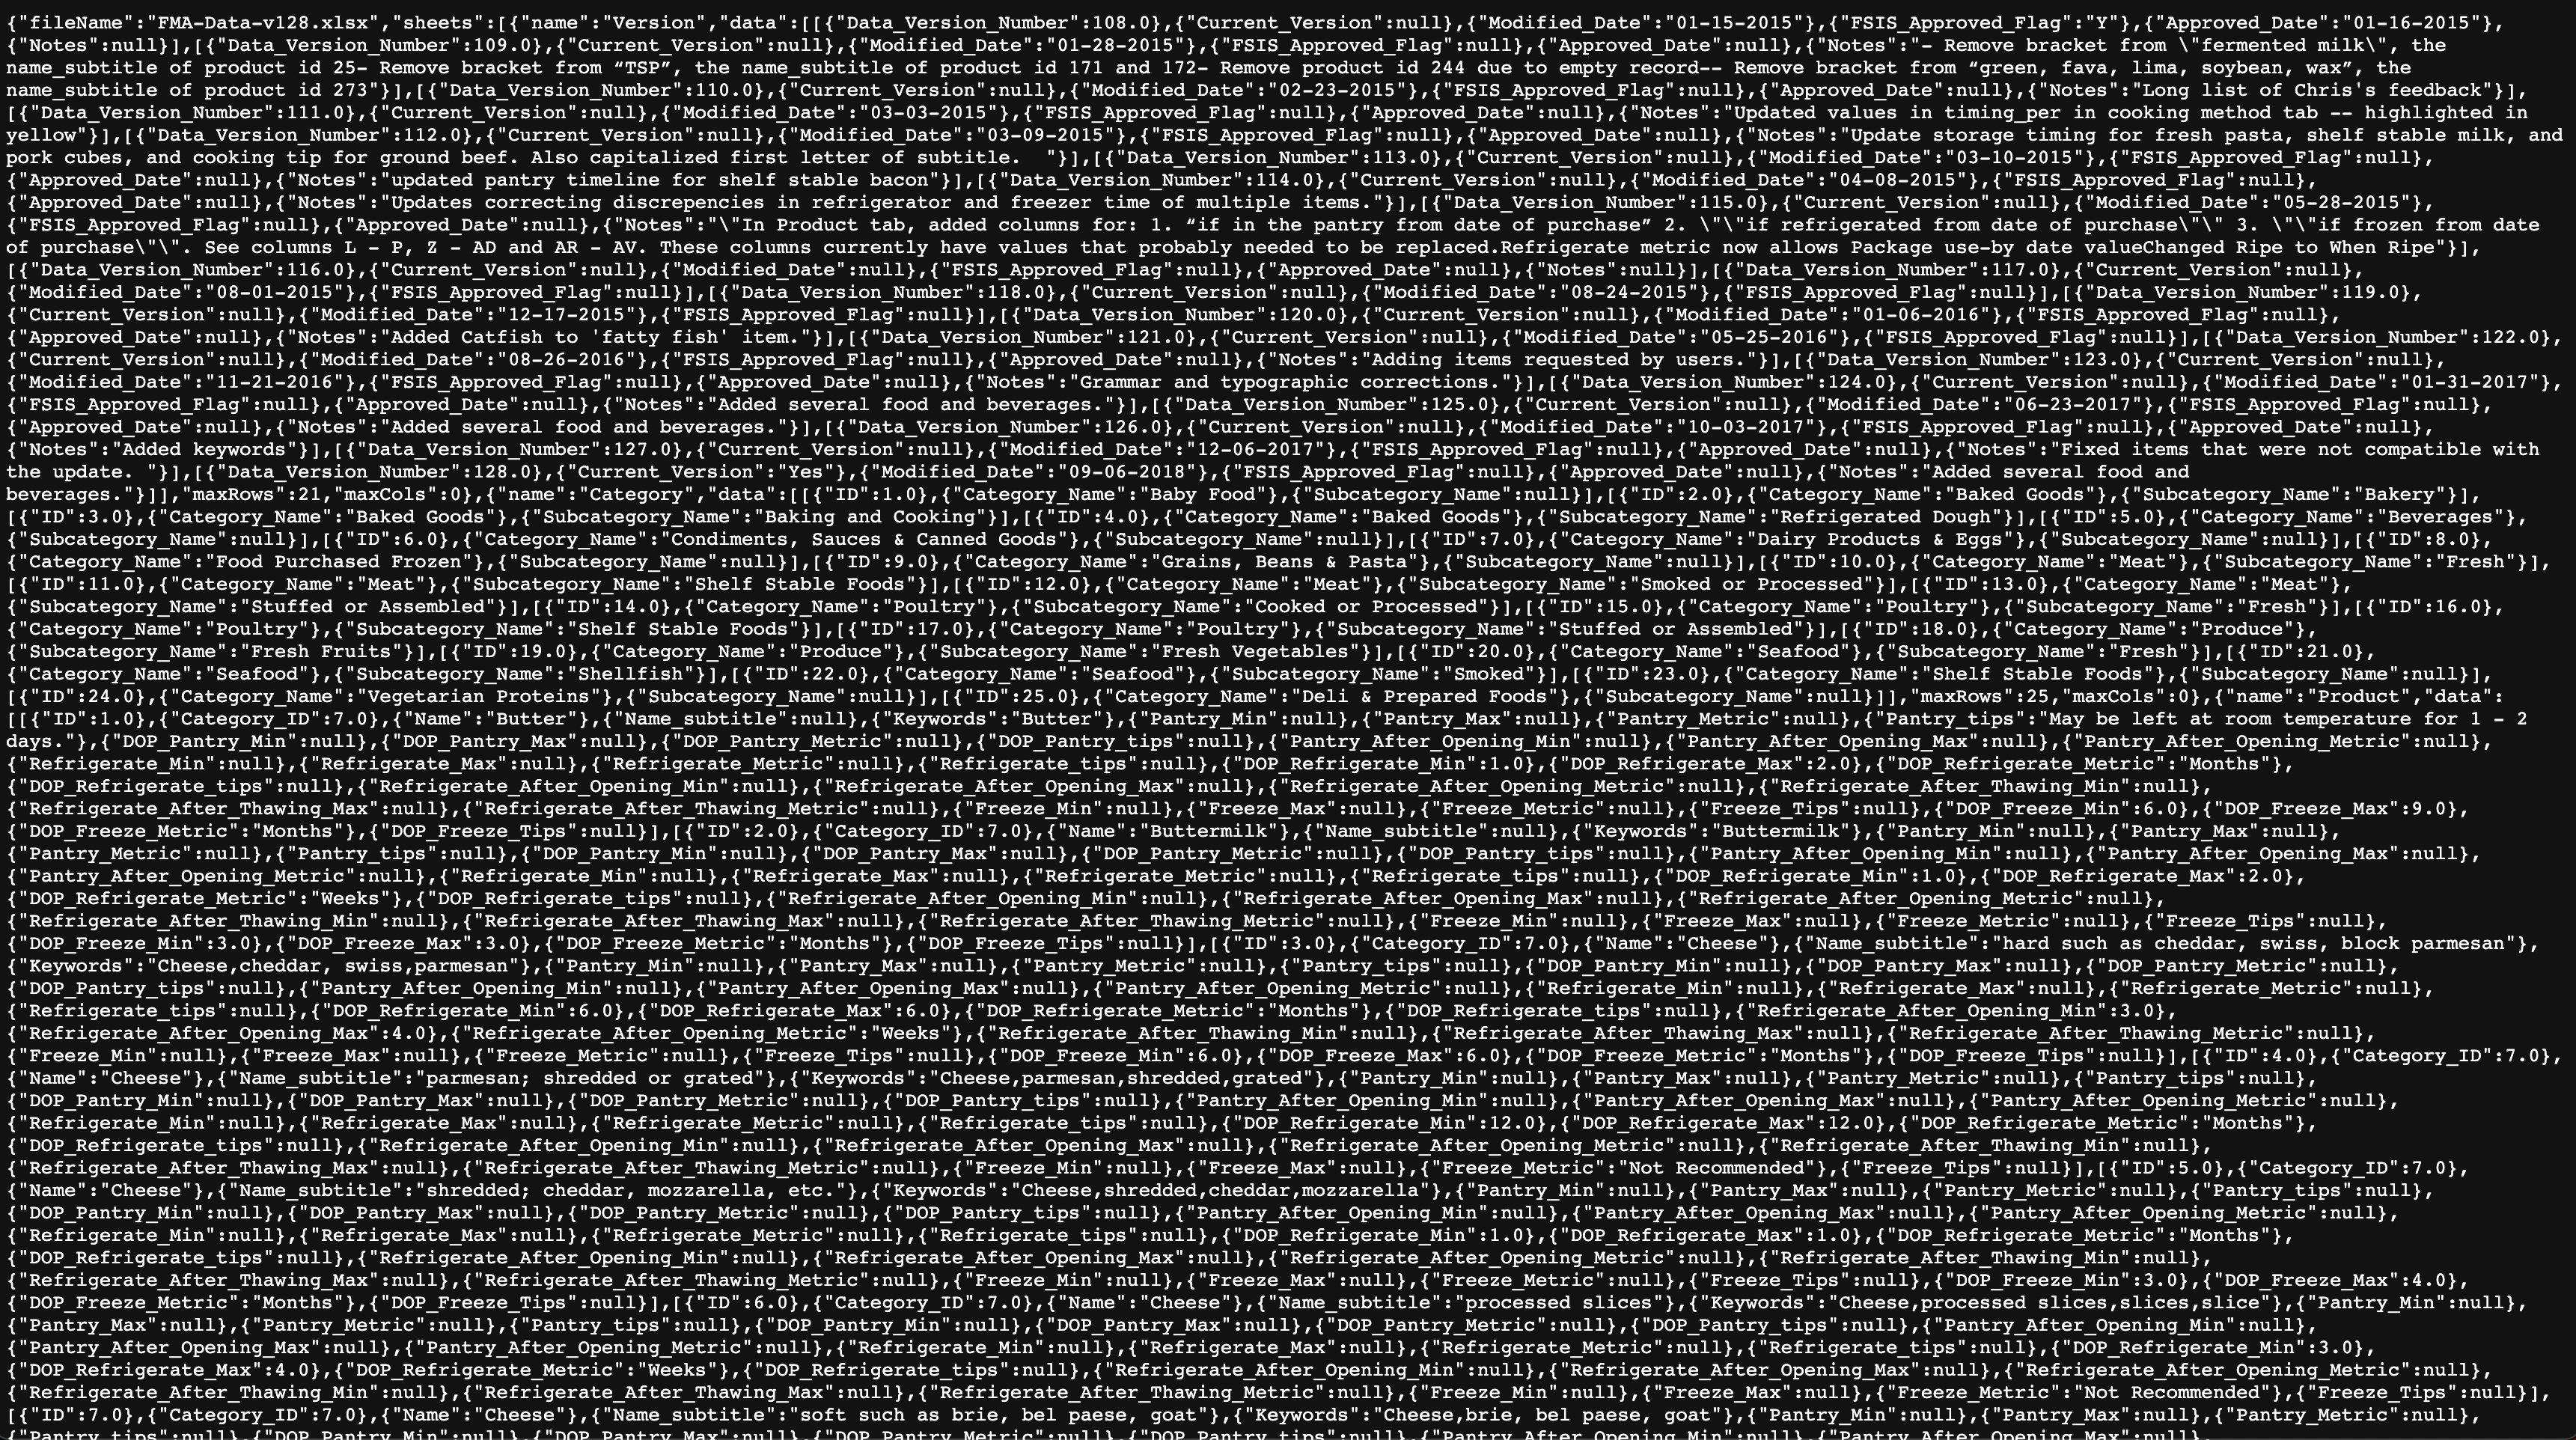

### Step 1: Understand the schema of the JSON
When I first get JSON data, the first thing I do is view the raw data to see if I can get a sense of the structure. Your job is easy If it's a straightforward schema, but the `FSIS FoodKeeper` dataset is not that.

Thus, I focus on pulling out the:
1. Dictionary keys
2. List values
3. Path to my desired data

Note how I am actively not printing the data, similar to when you use a pandas dataframe via `df.head()`. This is because doing so would print out way too much JSON data to make sense of it. We first have to find the path to our desired data and understand how to pull out a single record.

In [ ]:
# get the first level JSON keys
food_keeper_json.keys()

dict_keys(['fileName', 'sheets'])

In [ ]:
# looks like fileName is only one record, so we can ignore it
food_keeper_json['fileName']

'FMA-Data-v128.xlsx'

In [ ]:
# looks like sheets is only 6 values, but I know there is way more data, so the
# data we need has to be nested even further
len(food_keeper_json['sheets'])

6

In [ ]:
for i in food_keeper_json['sheets']:
    print(i.keys())

dict_keys(['name', 'data', 'maxRows', 'maxCols'])
dict_keys(['name', 'data', 'maxRows', 'maxCols'])
dict_keys(['name', 'data', 'maxRows', 'maxCols'])
dict_keys(['name', 'data', 'maxRows', 'maxCols'])
dict_keys(['name', 'data', 'maxRows', 'maxCols'])
dict_keys(['name', 'data', 'maxRows', 'maxCols'])


Thankfully the six values are structured the same, making our job easy in exploring the data. Once again, lets unravel the nested data even further by reviewing the keys and values for the dictionaries within the six values.

In [ ]:
list_index = 0
for sheet in food_keeper_json['sheets']:
    sheet_name = sheet['name']
    sheet_keys = sheet.keys()
    max_rows = sheet['maxRows']
    max_cols = sheet['maxCols']
    print(
        f'List Index: {list_index}',
        '\n',
        f'Sheet Name: {sheet_name}',
        '\n',
        f'Keys in Sheet List: {sheet_keys}',
        '\n',
        f'Max Rows: {max_rows}',
        '\n',
        f'Max Columns: {max_cols}',
         '\n',
        '-'*10,
        '\n'
        )
    list_index = list_index + 1


List Index: 0 
 Sheet Name: Version 
 Keys in Sheet List: dict_keys(['name', 'data', 'maxRows', 'maxCols']) 
 Max Rows: 21 
 Max Columns: 0 
 ---------- 

List Index: 1 
 Sheet Name: Category 
 Keys in Sheet List: dict_keys(['name', 'data', 'maxRows', 'maxCols']) 
 Max Rows: 25 
 Max Columns: 0 
 ---------- 

List Index: 2 
 Sheet Name: Product 
 Keys in Sheet List: dict_keys(['name', 'data', 'maxRows', 'maxCols']) 
 Max Rows: 661 
 Max Columns: 0 
 ---------- 

List Index: 3 
 Sheet Name: CookingTips 
 Keys in Sheet List: dict_keys(['name', 'data', 'maxRows', 'maxCols']) 
 Max Rows: 93 
 Max Columns: 0 
 ---------- 

List Index: 4 
 Sheet Name: CookingMethods 
 Keys in Sheet List: dict_keys(['name', 'data', 'maxRows', 'maxCols']) 
 Max Rows: 89 
 Max Columns: 0 
 ---------- 

List Index: 5 
 Sheet Name: Data Dictionary 
 Keys in Sheet List: dict_keys(['name', 'data', 'maxRows', 'maxCols']) 
 Max Rows: 62 
 Max Columns: 0 
 ---------- 



### Step 2: Identify the JSON data path
We finally found the product data all the way nested in the JSON with the path of `food_keeper_json['sheets'][2]['data']`. Note the quirk of the path not specifcally calling out "product" but instead is a list index number. This is the unique business logic that you have to keep track of and is a potential area of silent failure if it's in a production pipeline.

In addtion, we unfortunatly can't print `food_keeper_json['sheets'][2]['data']` as it's stored as a list and thus would print all of the product data. Let's intead just print the first record via `food_keeper_json['sheets'][2]['data'][0]`.

In [ ]:
food_keeper_json['sheets'][2]['data'][0]

[{'ID': 1.0},
 {'Category_ID': 7.0},
 {'Name': 'Butter'},
 {'Name_subtitle': None},
 {'Keywords': 'Butter'},
 {'Pantry_Min': None},
 {'Pantry_Max': None},
 {'Pantry_Metric': None},
 {'Pantry_tips': 'May be left at room temperature for 1 - 2 days.'},
 {'DOP_Pantry_Min': None},
 {'DOP_Pantry_Max': None},
 {'DOP_Pantry_Metric': None},
 {'DOP_Pantry_tips': None},
 {'Pantry_After_Opening_Min': None},
 {'Pantry_After_Opening_Max': None},
 {'Pantry_After_Opening_Metric': None},
 {'Refrigerate_Min': None},
 {'Refrigerate_Max': None},
 {'Refrigerate_Metric': None},
 {'Refrigerate_tips': None},
 {'DOP_Refrigerate_Min': 1.0},
 {'DOP_Refrigerate_Max': 2.0},
 {'DOP_Refrigerate_Metric': 'Months'},
 {'DOP_Refrigerate_tips': None},
 {'Refrigerate_After_Opening_Min': None},
 {'Refrigerate_After_Opening_Max': None},
 {'Refrigerate_After_Opening_Metric': None},
 {'Refrigerate_After_Thawing_Min': None},
 {'Refrigerate_After_Thawing_Max': None},
 {'Refrigerate_After_Thawing_Metric': None},
 {'Freeze_Min': 

### Step 3: Tranform the JSON data for analytics
We finally see the data value we need with `Refrigerate_Metric`, `Refrigerate_Min`, and `Refrigerate_Max`! But we have a problem...

The the data is a list of dictionaries in a list (`List[List[Dict[str:Any]]]`) and would require some extremely nasty code to directly query it. Thus we need to transform it into a single record so that we have a single list of dictionaries (`List[Dict[str:Any]]`).

In [ ]:
# testing out our merge dictionary function on an example
example_case = food_keeper_json['sheets'][2]['data'][0]

def merge_dictionaries(list_of_dicts):
    merged_dict = {}
    for dictionary in list_of_dicts:
        merged_dict.update(dictionary)
    return merged_dict

merge_dictionaries(example_case)

{'ID': 1.0,
 'Category_ID': 7.0,
 'Name': 'Butter',
 'Name_subtitle': None,
 'Keywords': 'Butter',
 'Pantry_Min': None,
 'Pantry_Max': None,
 'Pantry_Metric': None,
 'Pantry_tips': 'May be left at room temperature for 1 - 2 days.',
 'DOP_Pantry_Min': None,
 'DOP_Pantry_Max': None,
 'DOP_Pantry_Metric': None,
 'DOP_Pantry_tips': None,
 'Pantry_After_Opening_Min': None,
 'Pantry_After_Opening_Max': None,
 'Pantry_After_Opening_Metric': None,
 'Refrigerate_Min': None,
 'Refrigerate_Max': None,
 'Refrigerate_Metric': None,
 'Refrigerate_tips': None,
 'DOP_Refrigerate_Min': 1.0,
 'DOP_Refrigerate_Max': 2.0,
 'DOP_Refrigerate_Metric': 'Months',
 'DOP_Refrigerate_tips': None,
 'Refrigerate_After_Opening_Min': None,
 'Refrigerate_After_Opening_Max': None,
 'Refrigerate_After_Opening_Metric': None,
 'Refrigerate_After_Thawing_Min': None,
 'Refrigerate_After_Thawing_Max': None,
 'Refrigerate_After_Thawing_Metric': None,
 'Freeze_Min': None,
 'Freeze_Max': None,
 'Freeze_Metric': None,
 'Freeze_T

In [ ]:
# creating a list of dictionaries
dict_list = []
for data in food_keeper_json['sheets'][2]['data']:
    merged_dict = merge_dictionaries(data)
    dict_list.append(merged_dict)

dict_list[0:2]

[{'ID': 1.0,
  'Category_ID': 7.0,
  'Name': 'Butter',
  'Name_subtitle': None,
  'Keywords': 'Butter',
  'Pantry_Min': None,
  'Pantry_Max': None,
  'Pantry_Metric': None,
  'Pantry_tips': 'May be left at room temperature for 1 - 2 days.',
  'DOP_Pantry_Min': None,
  'DOP_Pantry_Max': None,
  'DOP_Pantry_Metric': None,
  'DOP_Pantry_tips': None,
  'Pantry_After_Opening_Min': None,
  'Pantry_After_Opening_Max': None,
  'Pantry_After_Opening_Metric': None,
  'Refrigerate_Min': None,
  'Refrigerate_Max': None,
  'Refrigerate_Metric': None,
  'Refrigerate_tips': None,
  'DOP_Refrigerate_Min': 1.0,
  'DOP_Refrigerate_Max': 2.0,
  'DOP_Refrigerate_Metric': 'Months',
  'DOP_Refrigerate_tips': None,
  'Refrigerate_After_Opening_Min': None,
  'Refrigerate_After_Opening_Max': None,
  'Refrigerate_After_Opening_Metric': None,
  'Refrigerate_After_Thawing_Min': None,
  'Refrigerate_After_Thawing_Max': None,
  'Refrigerate_After_Thawing_Metric': None,
  'Freeze_Min': None,
  'Freeze_Max': None,
  

# Step 4: Convert the transformed data into a flat file and analyze it
We have now extracted our desired JSON data and tranformed it into a format that can be turned into a flat file for analytics. One major aspect I want to note is that we got lucky that the nested data has the same keys for every record. When I worked on similar problems in industry, I will often come across nested records with different keys due to nulls or many other quircks. Most of my time creating production data pipelines is figuring out these edge cases to account for them and build unit tests.

In [ ]:
food_keeper_product_df = pd.DataFrame(dict_list)
food_keeper_product_df.head()

,ID,Category_ID,Name,Name_subtitle,Keywords,Pantry_Min,Pantry_Max,Pantry_Metric,Pantry_tips,DOP_Pantry_Min,...,Refrigerate_After_Thawing_Max,Refrigerate_After_Thawing_Metric,Freeze_Min,Freeze_Max,Freeze_Metric,Freeze_Tips,DOP_Freeze_Min,DOP_Freeze_Max,DOP_Freeze_Metric,DOP_Freeze_Tips
0,1.0,7.0,Butter,None,Butter,NaN,NaN,None,May be left at room temperature for 1 - 2 days.,NaN,...,NaN,None,NaN,NaN,None,None,6.0,9.0,Months,None
1,2.0,7.0,Buttermilk,None,Buttermilk,NaN,NaN,None,None,NaN,...,NaN,None,NaN,NaN,None,None,3.0,3.0,Months,None
2,3.0,7.0,Cheese,"hard such as cheddar, swiss, block parmesan","Cheese,cheddar, swiss,parmesan",NaN,NaN,None,None,NaN,...,NaN,None,NaN,NaN,None,None,6.0,6.0,Months,None
3,4.0,7.0,Cheese,parmesan; shredded or grated,"Cheese,parmesan,shredded,grated",NaN,NaN,None,None,NaN,...,NaN,None,NaN,NaN,Not Recommended,None,NaN,NaN,NaN,NaN
4,5.0,7.0,Cheese,"shredded; cheddar, mozzarella, etc.","Cheese,shredded,cheddar,mozzarella",NaN,NaN,None,None,NaN,...,NaN,None,NaN,NaN,None,None,3.0,4.0,Months,None


### Step 5: Answer the business question for your stakeholders

Now we have moved out of JSON and are in a more familiar space for data teams using dataframes.

We have identified the following food products that are not recommended to be stored in the refrigerator:
- Turducken
- Frozen potato products: fries, hashbrowns, tater tots
- Pancakes, waffles
- Sherbet, sorbet
- Frozen entrees: prepared meals
- Pumpkin seeds: raw, in-shell

In [ ]:
food_keeper_product_df['Refrigerate_Metric'].unique()

array([None, 'Days', 'Weeks', 'Package use-by date', 'Months',
       'Not Recommended', nan, 'Years', 'Indefinitely'], dtype=object)

In [ ]:
food_keeper_product_df[food_keeper_product_df['Refrigerate_Metric']=='Not Recommended']

,ID,Category_ID,Name,Name_subtitle,Keywords,Pantry_Min,Pantry_Max,Pantry_Metric,Pantry_tips,DOP_Pantry_Min,...,Refrigerate_After_Thawing_Max,Refrigerate_After_Thawing_Metric,Freeze_Min,Freeze_Max,Freeze_Metric,Freeze_Tips,DOP_Freeze_Min,DOP_Freeze_Max,DOP_Freeze_Metric,DOP_Freeze_Tips
122,133.0,17.0,Turducken,None,Turducken,NaN,NaN,None,None,NaN,...,NaN,None,NaN,NaN,None,None,9.0,9.0,Months,None
291,311.0,8.0,Fish,breaded,"Fish,breaded,bread",NaN,NaN,None,None,NaN,...,NaN,None,NaN,NaN,None,None,18.0,18.0,Months,"Keep frozen. For safety, cook as directed."
293,313.0,8.0,Frozen potato products,"fries, hashbrowns, tater tots","Frozen potato products,fries,hashbrowns,tater ...",NaN,NaN,None,None,NaN,...,NaN,None,NaN,NaN,None,None,12.0,12.0,Months,"Keep frozen. For safety, cook as directed."
300,321.0,8.0,"Pancakes, waffles",None,"Pancakes,waffles,pancake",NaN,NaN,None,None,NaN,...,NaN,None,NaN,NaN,None,None,3.0,3.0,Months,"Keep frozen. For safety, cook as directed."
303,324.0,8.0,"Sherbet, sorbet",None,"Sherbet,sorbet",NaN,NaN,None,None,NaN,...,NaN,None,NaN,NaN,None,None,9.0,9.0,Months,None
308,330.0,8.0,Frozen entrees,prepared meals,"TV dinners,entrees,breakfast,dinners,dinner,en...",NaN,NaN,None,None,NaN,...,NaN,None,NaN,NaN,None,None,12.0,12.0,Months,"Keep frozen. For safety, cook as directed."
581,605.0,23.0,Pumpkin seeds,"raw, in-shell","pumpkin,pumpkin seed,pumpkin seeds,seed,seeds",6.0,6.0,Months,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Conclusion
This wraps up our **Intro to Analyzing JSON Data with Python**! To provide some more market context, the above pattern in this exercise is what you find in traditional ETL data pipelines. ETL pipelines are tried and true design patterns, but you saw how much work went into getting our data. You typically need to have your application data as a document store such as JSON to quickly access data for transactions (e.g. clicking through a product or website) and another seperate database that data is loaded into and transformed for analytics purposes.

We are now starting to see a shift in our industry where the transactional database AND the analytics database is being combined so you can do both. Though it increases the complexity of the single database, it reduces the number of transformations and handoffs thus reducing the complexity of the entire data system! The sponsor of this content is one of those databases!

###**A huge thank you to SingleStore for sponsoring this content, and providing an opportunity for me to grow as a data content creator! If you found this tutorial helpful, then please check out a more in depth workshop on JSON analytics. Every signup goes a long way in helping me out!**

🔗 [LINK TO JSON ANALYTICS WORKSHOP](https://www.singlestore.com/resources/webinar-product-launch-100x-faster-json-analytics-over-mongodb-mark-2023-05/) 🔗

*P.S. It's okay if you can't make the live session. Everyone who signs up should receive a recording and a tutorial to follow along with at a later time!*

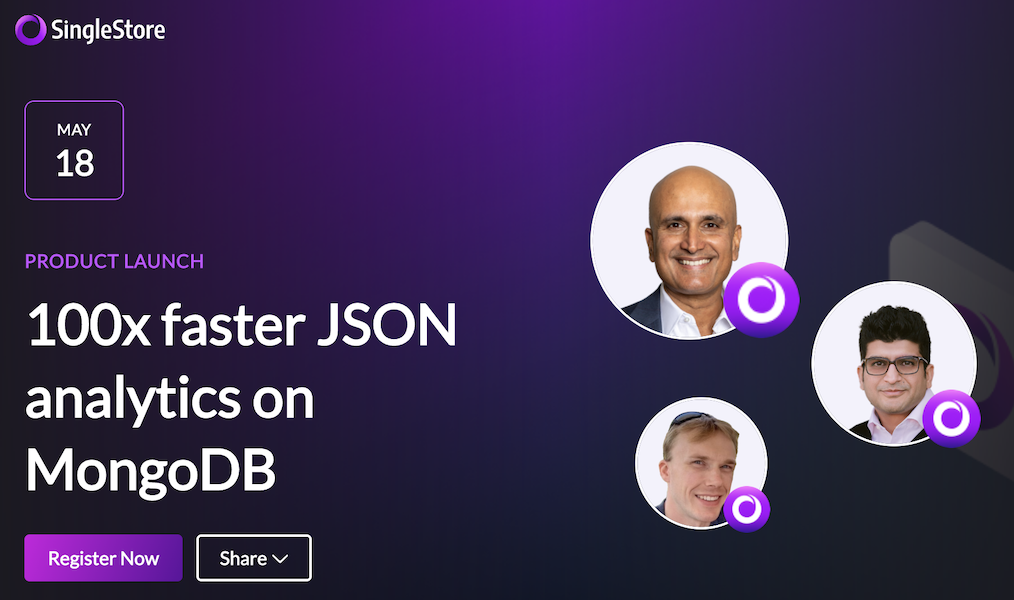